# Data Cleaning Pipeline

In [1]:
# Only need to assign the two values below first, then run all
watershed = 'NorthernGulfofAlaska'
main_str = 'Dwnstr'

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy
from pandas.plotting import register_matplotlib_converters
from sklearn import linear_model
from sklearn.metrics import r2_score
import copy
import os
import matplotlib.backends.backend_pdf
lm = linear_model.LinearRegression()
np.random.seed(50)
plt.rcParams.update({'figure.max_open_warning': 0})
register_matplotlib_converters()
os.getcwd()

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/17-NGA/DailyData'

In [3]:
# local functions
import sys
sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')

from Abnormal_data_values_control import outvalues,threC
from Source_QC_functions_L import interpolateQC, regressorFunc, funcClimateCatalog, AssembleClimateCatalog

In [4]:
# Read the original data table
table = pd.read_csv('1_'+watershed+'_Download_Aggregation_Daily.csv',header = 0,index_col = 'DateTime',
                    parse_dates = True, infer_datetime_format = True,low_memory=False)
display(table.head(2))
display(table.tail(2))

Dwnstr_Discharge  Upstr_Discharge  CMR_Precipitation  \
DateTime                                                           
2012-09-26               NaN              NaN                0.0   
2012-09-27               NaN              NaN                0.0   

            CMR_AirTemperature_1m  CMR_AirTemperature_2m  CMR_SolarRadiation  \
DateTime                                                                       
2012-09-26                 4.4020                4.79900                 NaN   
2012-09-27                 3.7025                3.80625                 NaN   

            CMR_RelativeHumidity_1m  CMR_RelativeHumidity_2m  \
DateTime                                                       
2012-09-26                 47.24600                45.355000   
2012-09-27                 54.34875                53.600833   

            CMR_WindDirection  CMR_WindSpeed  ...  CMR_SoilTemperature_5cm  \
DateTime                                      ...                            
2012-09-26         188.730000          2.531  ...                 4.068300   
2012-09-27         187.329167         10.130  ...                 2.844875   

            CMR_SoilTemperature_10cm  CMR_SoilTemperature_15cm  \
DateTime                                                         
2012-09-26                  4.042000                  3.990300   
2012-09-27                  2.878958                  3.031125   

            CMR_SoilTemperature_20cm  CMR_SoilTemperature_30cm  \
DateTime                                                         
2012-09-26                  3.930800                  3.668900   
2012-09-27                  3.146417                  3.291375   

            CMR_SoilTemperature_40cm  CMR_SoilTemperature_50cm  \
DateTime                                                         
2012-09-26                    3.3995                  3.250000   
2012-09-27                    3.2545                  3.209875   

            CMR_SoilTemperature_75cm  CMR_SoilTemperature_100cm  \
DateTime                                                          
2012-09-26                  3.050300                    2.79280   
2012-09-27                  2.974083                    2.72575   

            CMR_SoilTemperature_125cm  
DateTime                               
2012-09-26                     2.5147  
2012-09-27                     2.4595  

[2 rows x 25 columns]

Dwnstr_Discharge  Upstr_Discharge  CMR_Precipitation  \
DateTime                                                           
2016-12-30               NaN              NaN                0.0   
2016-12-31               NaN              NaN                0.0   

            CMR_AirTemperature_1m  CMR_AirTemperature_2m  CMR_SolarRadiation  \
DateTime                                                                       
2016-12-30              -6.260292              -5.970167            1.438167   
2016-12-31              -3.531958              -2.948708            2.476375   

            CMR_RelativeHumidity_1m  CMR_RelativeHumidity_2m  \
DateTime                                                       
2016-12-30                67.230000                63.993125   
2016-12-31                40.636458                37.146667   

            CMR_WindDirection  CMR_WindSpeed  ...  CMR_SoilTemperature_5cm  \
DateTime                                      ...                            
2016-12-30         127.735833        5.46925  ...                -4.484208   
2016-12-31         125.469167        5.69975  ...                -4.657000   

            CMR_SoilTemperature_10cm  CMR_SoilTemperature_15cm  \
DateTime                                                         
2016-12-30                 -4.339708                 -4.113875   
2016-12-31                 -4.376708                 -4.067417   

            CMR_SoilTemperature_20cm  CMR_SoilTemperature_30cm  \
DateTime                                                         
2016-12-30                 -3.970708                 -3.417042   
2016-12-31                 -3.878583                 -3.278500   

            CMR_SoilTemperature_40cm  CMR_SoilTemperature_50cm  \
DateTime                                                         
2016-12-30                 -3.280542                 -2.836875   
2016-12-31                 -3.137750                 -2.720583   

            CMR_SoilTemperature_75cm  CMR_SoilTemperature_100cm  \
DateTime                                                          
2016-12-30                 -1.859375                  -0.911708   
2016-12-31                 -1.829708                  -0.929333   

            CMR_SoilTemperature_125cm  
DateTime                               
2016-12-30                  -0.102542  
2016-12-31                  -0.133542  

[2 rows x 25 columns]

In [5]:
# Check all the station names
all_stations = table.columns.str.extract(r'([^_]+)')[0]
print('All stations names: ', all_stations.unique())
print ('  ')
nameStrflwStation=[]
nameHydrMetStation=[]
for i in np.arange(len(table.columns)):
    if table.columns[i][-9:]=='Discharge':  ### 
        if not all_stations[i] in nameStrflwStation:
            nameStrflwStation.append(all_stations[i]) ### 
    else:
        if not all_stations[i] in nameHydrMetStation:
            nameHydrMetStation.append(all_stations[i])  ### 

print('Discharge stations :',nameStrflwStation)
print('  ')
print('Meteorology stations:',nameHydrMetStation)                  

All stations names:  ['Dwnstr' 'Upstr' 'CMR']
  
Discharge stations : ['Dwnstr', 'Upstr']
  
Meteorology stations: ['CMR']


In [6]:
for i in table.columns:
    if i.split('_')[0] == main_str :
        print(i)

Dwnstr_Discharge


In [7]:
len(nameHydrMetStation)

1

#  1. Trim the original table

In [8]:
# Trim the data and let the table start with first non nan value, end with last non nan value
# Identify the first non nan value in each column as the starting date.
# Identify the last non nan value in each column as the ending date.

t = table.notna() 
t = ~np.isnan(table)
col = len(t.columns)
b = np.zeros([table.shape[1]])
c = np.array([table.shape[0]] * table.shape[1])

for i in range(col):
    if any(t.iloc[:,i]): # Since some are empty
        b[i] = list(np.where(t.iloc[:,i] == True))[0][0] # the first non nan value location
        c[i] = list(np.where(t.iloc[:,i] == True))[0][-1] # the last non nan value location
        
st_tab = b.min()
table1 = table.iloc[int(b.min()):int(c.max()) + 1,:] 

# Display the trimmed table
display(table1.head(2))
display(table1.tail(2))
print('trimmed row number is ', int(table.shape[0] -  table1.shape[0]))

Dwnstr_Discharge  Upstr_Discharge  CMR_Precipitation  \
DateTime                                                           
2012-09-26               NaN              NaN                0.0   
2012-09-27               NaN              NaN                0.0   

            CMR_AirTemperature_1m  CMR_AirTemperature_2m  CMR_SolarRadiation  \
DateTime                                                                       
2012-09-26                 4.4020                4.79900                 NaN   
2012-09-27                 3.7025                3.80625                 NaN   

            CMR_RelativeHumidity_1m  CMR_RelativeHumidity_2m  \
DateTime                                                       
2012-09-26                 47.24600                45.355000   
2012-09-27                 54.34875                53.600833   

            CMR_WindDirection  CMR_WindSpeed  ...  CMR_SoilTemperature_5cm  \
DateTime                                      ...                            
2012-09-26         188.730000          2.531  ...                 4.068300   
2012-09-27         187.329167         10.130  ...                 2.844875   

            CMR_SoilTemperature_10cm  CMR_SoilTemperature_15cm  \
DateTime                                                         
2012-09-26                  4.042000                  3.990300   
2012-09-27                  2.878958                  3.031125   

            CMR_SoilTemperature_20cm  CMR_SoilTemperature_30cm  \
DateTime                                                         
2012-09-26                  3.930800                  3.668900   
2012-09-27                  3.146417                  3.291375   

            CMR_SoilTemperature_40cm  CMR_SoilTemperature_50cm  \
DateTime                                                         
2012-09-26                    3.3995                  3.250000   
2012-09-27                    3.2545                  3.209875   

            CMR_SoilTemperature_75cm  CMR_SoilTemperature_100cm  \
DateTime                                                          
2012-09-26                  3.050300                    2.79280   
2012-09-27                  2.974083                    2.72575   

            CMR_SoilTemperature_125cm  
DateTime                               
2012-09-26                     2.5147  
2012-09-27                     2.4595  

[2 rows x 25 columns]

Dwnstr_Discharge  Upstr_Discharge  CMR_Precipitation  \
DateTime                                                           
2016-12-30               NaN              NaN                0.0   
2016-12-31               NaN              NaN                0.0   

            CMR_AirTemperature_1m  CMR_AirTemperature_2m  CMR_SolarRadiation  \
DateTime                                                                       
2016-12-30              -6.260292              -5.970167            1.438167   
2016-12-31              -3.531958              -2.948708            2.476375   

            CMR_RelativeHumidity_1m  CMR_RelativeHumidity_2m  \
DateTime                                                       
2016-12-30                67.230000                63.993125   
2016-12-31                40.636458                37.146667   

            CMR_WindDirection  CMR_WindSpeed  ...  CMR_SoilTemperature_5cm  \
DateTime                                      ...                            
2016-12-30         127.735833        5.46925  ...                -4.484208   
2016-12-31         125.469167        5.69975  ...                -4.657000   

            CMR_SoilTemperature_10cm  CMR_SoilTemperature_15cm  \
DateTime                                                         
2016-12-30                 -4.339708                 -4.113875   
2016-12-31                 -4.376708                 -4.067417   

            CMR_SoilTemperature_20cm  CMR_SoilTemperature_30cm  \
DateTime                                                         
2016-12-30                 -3.970708                 -3.417042   
2016-12-31                 -3.878583                 -3.278500   

            CMR_SoilTemperature_40cm  CMR_SoilTemperature_50cm  \
DateTime                                                         
2016-12-30                 -3.280542                 -2.836875   
2016-12-31                 -3.137750                 -2.720583   

            CMR_SoilTemperature_75cm  CMR_SoilTemperature_100cm  \
DateTime                                                          
2016-12-30                 -1.859375                  -0.911708   
2016-12-31                 -1.829708                  -0.929333   

            CMR_SoilTemperature_125cm  
DateTime                               
2016-12-30                  -0.102542  
2016-12-31                  -0.133542  

[2 rows x 25 columns]

trimmed row number is  0


### Drop columns without data

In [9]:
tt = copy.deepcopy(table1)
for dd in np.arange(len(tt.columns)):
    if all(pd.isna(tt.iloc[:,dd])):
        print('The empty column is ', dd,tt.columns[dd])
        table1.drop(columns = tt.columns[dd], axis=1, inplace = True)

var_number = table1.shape[1] 

if table1.shape[1]  == table.shape[1] :
    print('There are no empty columns!')

There are no empty columns!


### Save the original discharge table seperately

In [10]:
DischargeTable = pd.DataFrame(index = table1.index)
for i in np.arange(len(nameStrflwStation)):
    DischargeTable[nameStrflwStation[i]+'_Discharge'] = table1.loc[:,nameStrflwStation[i]+'_Discharge']

DischargeTable.to_csv('1_'+ watershed + '_DischargeTable.csv')

# 2. Data filling method: Interpolation

0 Dwnstr_Discharge index of interpolated length = 46
No filled values are out of original data range
 
1 Upstr_Discharge index of interpolated length = 14
No filled values are out of original data range
 
 
2 CMR_Precipitation :No missing data!
3 CMR_AirTemperature_1m index of interpolated length = 89
No filled values are out of original data range
 
4 CMR_AirTemperature_2m index of interpolated length = 80
No filled values are out of original data range
 
5 CMR_SolarRadiation index of interpolated length = 121
No filled values are out of original data range
 
6 CMR_RelativeHumidity_1m index of interpolated length = 28
No filled values are out of original data range
 
7 CMR_RelativeHumidity_2m index of interpolated length = 38
No filled values are out of original data range
 
8 CMR_WindDirection index of interpolated length = 28
No filled values are out of original data range
 
9 CMR_WindSpeed index of interpolated length = 39
No filled values are out of original data range
 
10 CMR_Sn

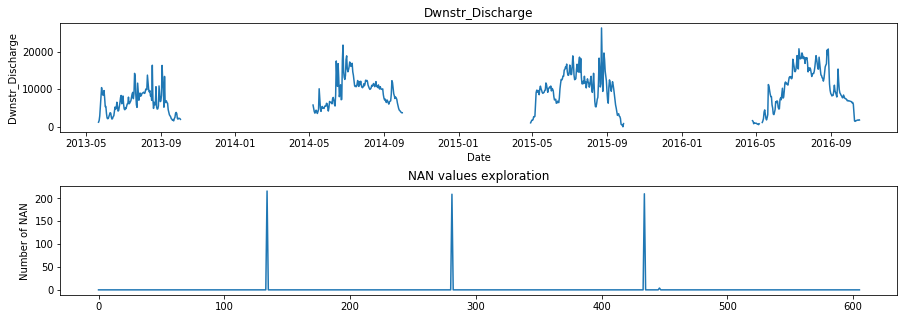

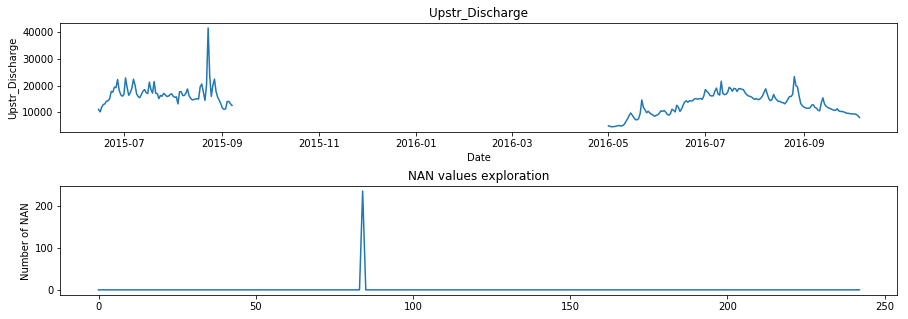

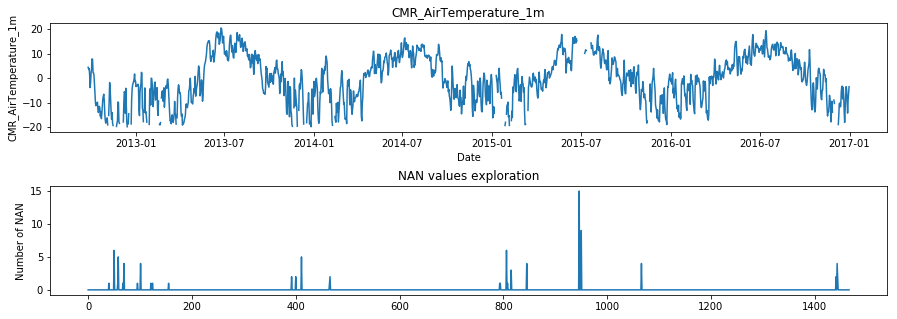

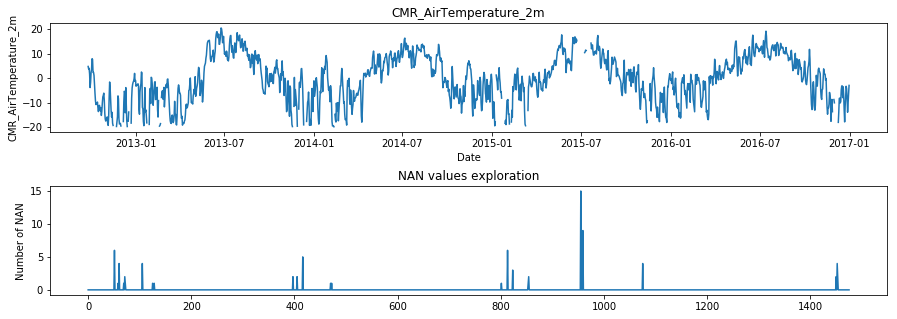

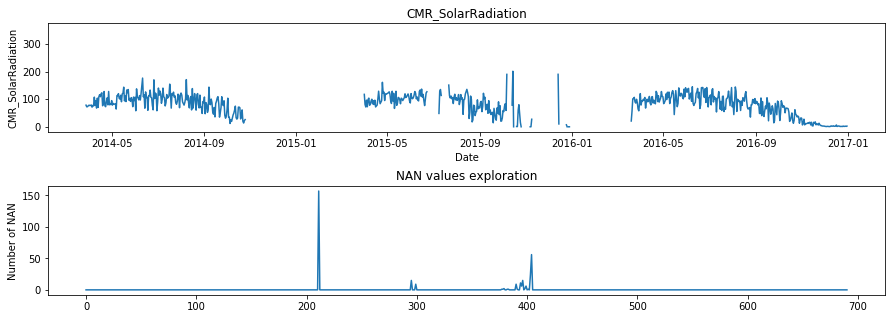

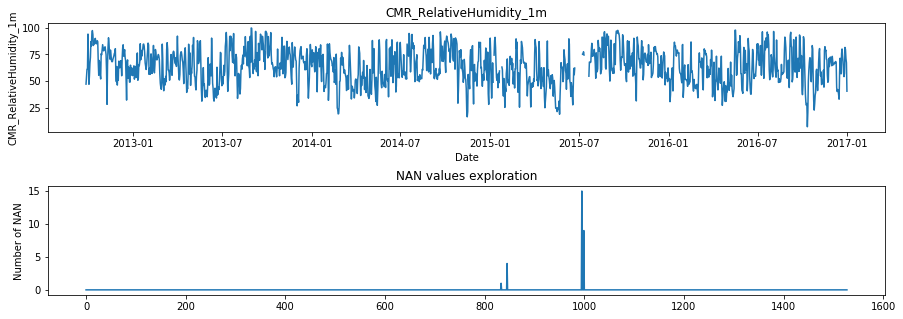

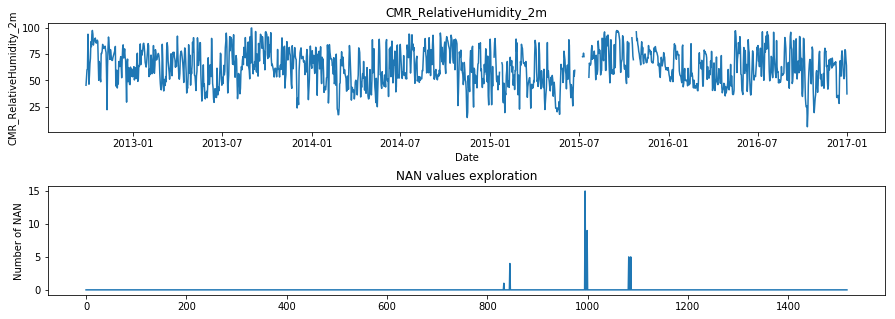

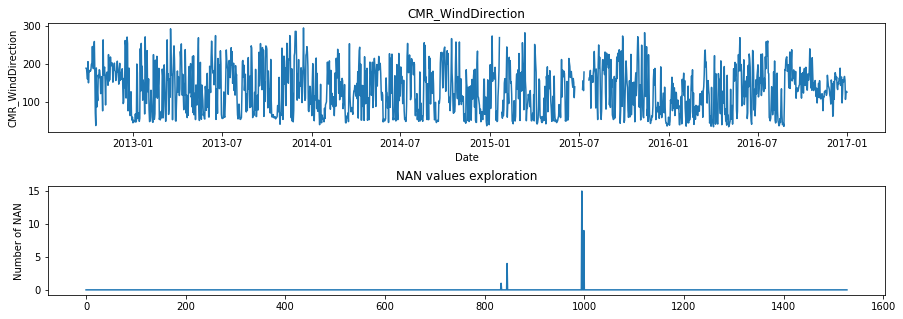

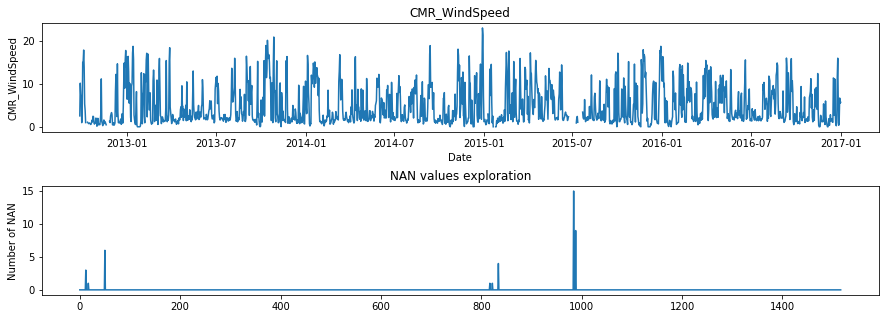

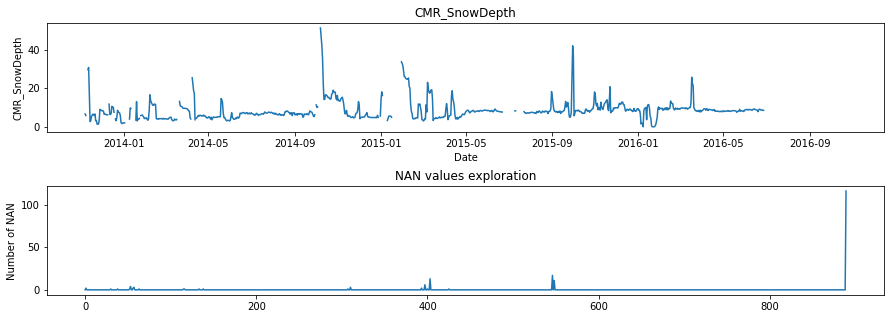

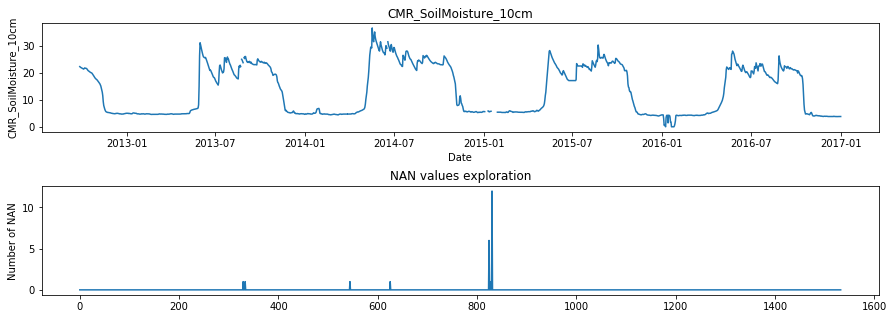

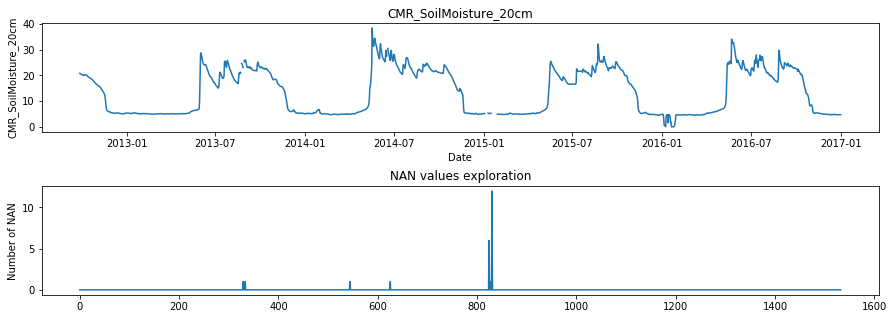

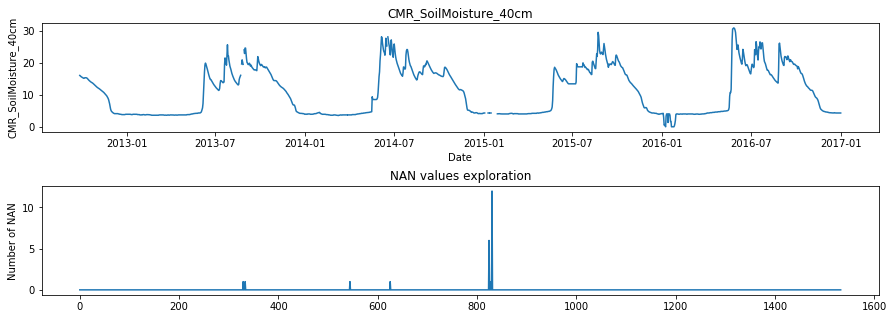

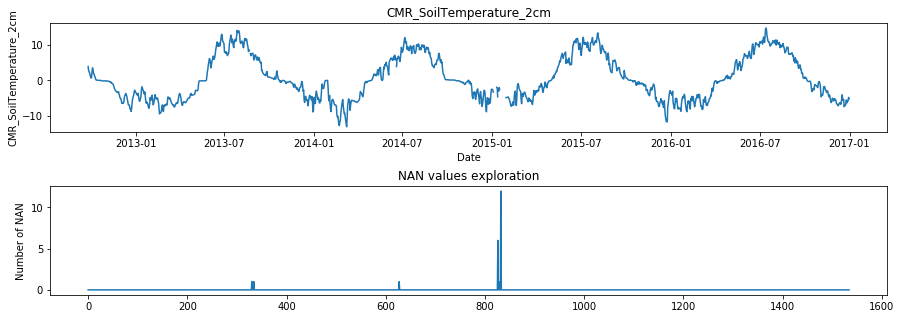

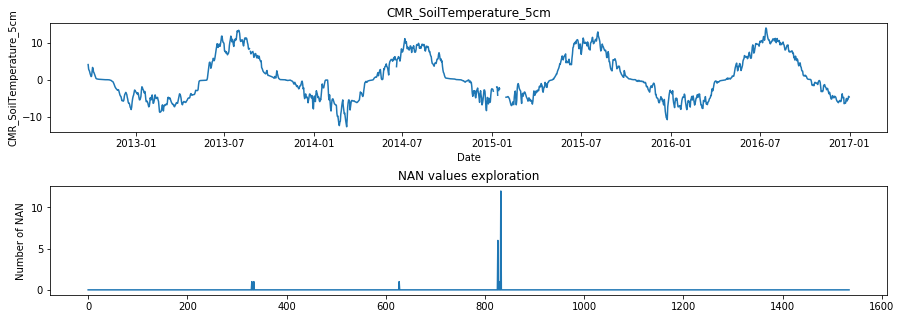

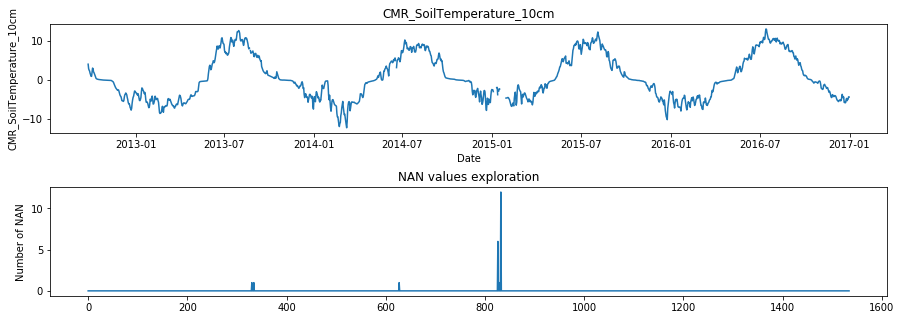

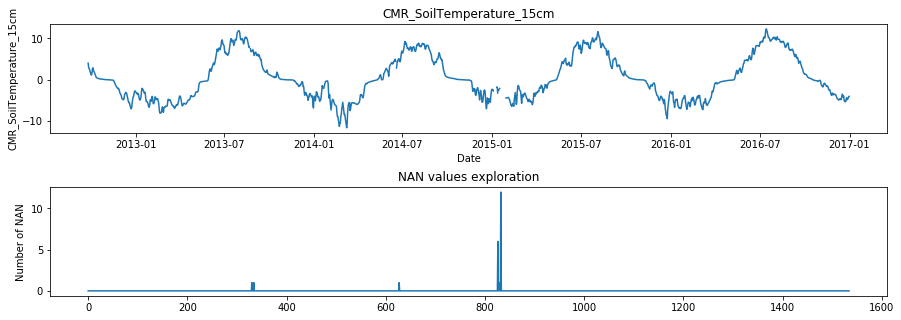

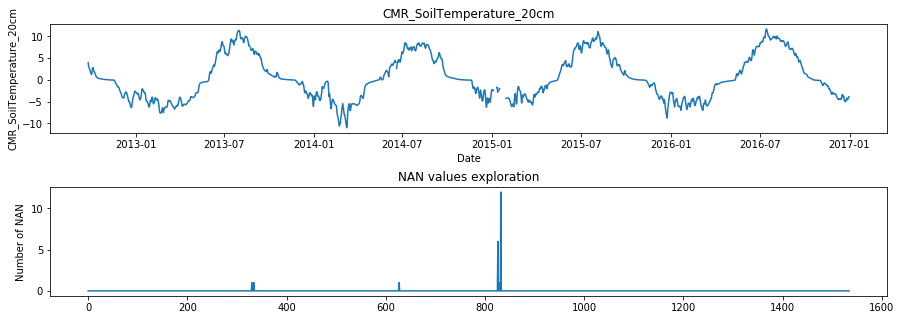

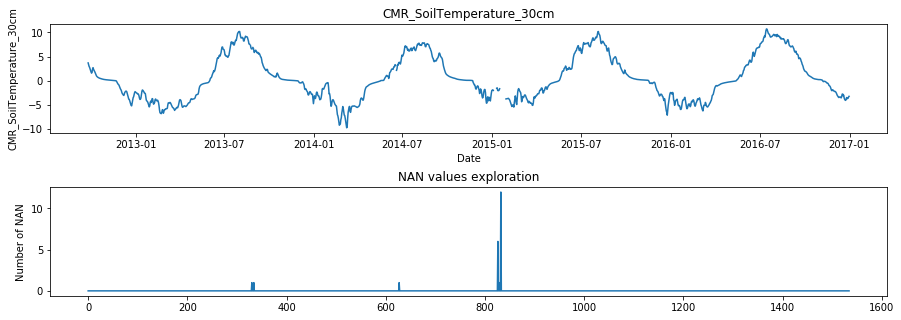

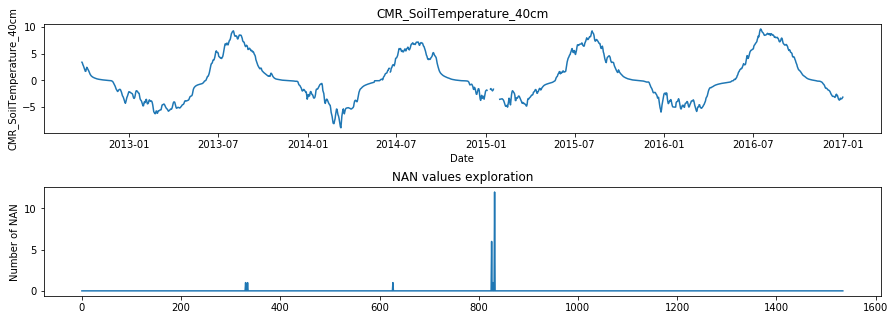

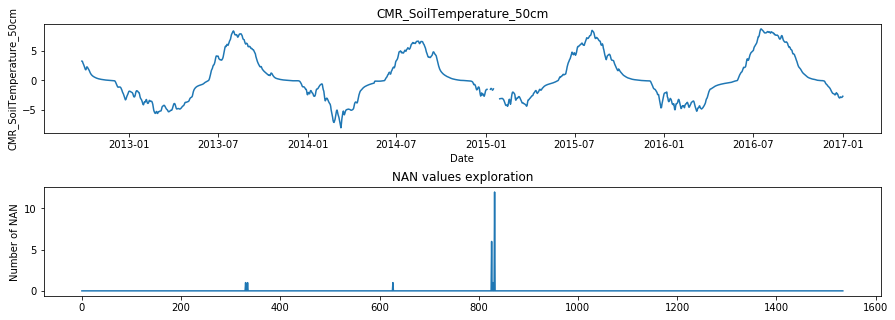

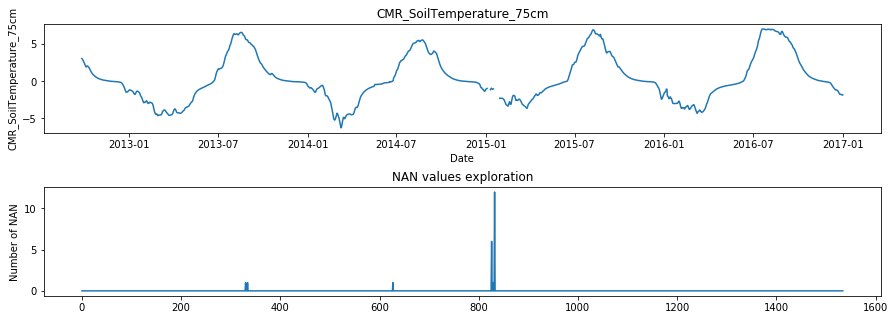

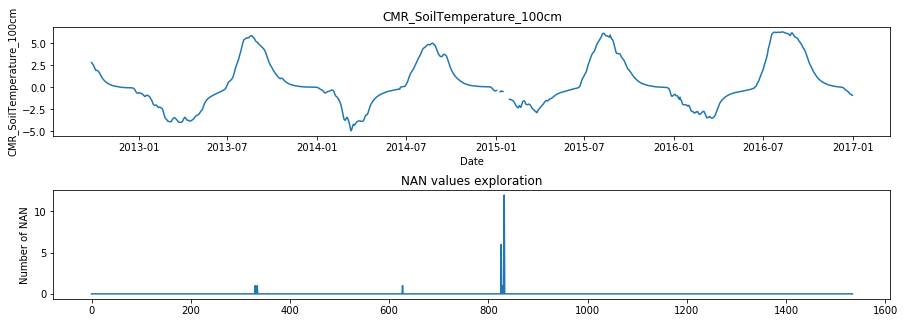

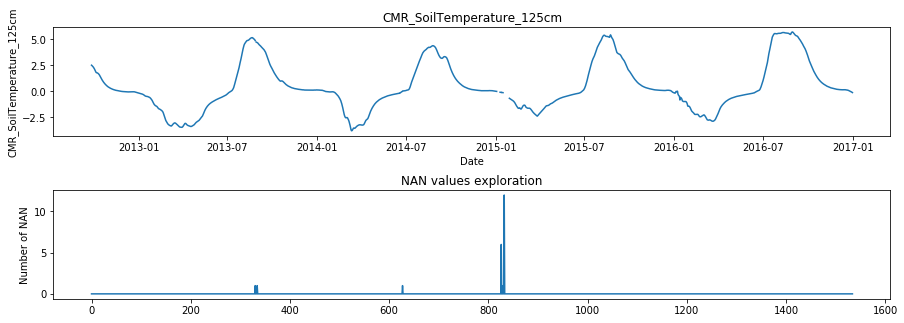

In [11]:
# =====================================
# First data exploration with plots.
# Check the number of Missing values.
# Do interpolation on the missing values positions

# table 2 will be used to be updated with interpolated values
table2=copy.deepcopy(table1) 

# a dictionary that store data record for each column
y1={} 

# Create a flag table(flag_table2) to store interpolation indicators
indexUnique=table2.index
ready_columns=pd.unique(table2.columns) 
if len(pd.unique(table2.columns))!=len(table2.columns):
    print("Duplicate columns exist!")
flag_table2=pd.DataFrame(np.nan*np.ones([len(indexUnique),len(ready_columns)]),
                 index = indexUnique, columns=ready_columns) 


for k,VarName in enumerate(ready_columns): # column of variable being processed 
    y1[k]=table2[VarName].copy(deep = True)
    ind=np.where(~np.isnan(y1[k].to_numpy())) # index where y1 has value (not NaN)
    flag_table2[VarName][ind[0]] = int(1) # set indicator 1 to original data positions
    start = ind[0][0]
    end = ind[0][-1]
    missing_index = list(set(range(start,end+1)) - set(ind[0]))
    flag_table2[VarName][missing_index] = int(0) # set indicator 0 to missing data positions
    y1[k] = y1[k][start:end+1] # trim y1   
    
    # Print out whether the column contain missing values
    dim = np.shape(ind)[1] # number of exsiting data points 
    if (dim != len(y1[k])): # there are missing data
        #===========================
        # For those columns that contain missing values:Plot the data and indicate nan values position and length
        fig1 = plt.figure(figsize=[15,5])
        sp1, sp2 = fig1.add_subplot(211), fig1.add_subplot(212)
        sp1.plot(y1[k])
        sp1.set_title(table2.columns[k])
        sp1.set_xlabel('Date')
        sp1.set_ylabel(table2.columns[k])
    
        index = np.argwhere(~np.isnan(y1[k].to_numpy())) # An array of index that the value is not nan (where data exist)
        lenNAN = (np.diff(index,axis=0)) - 1 # An array that indicate the NAN value number along data record

        pd.DataFrame(lenNAN)
        sp2.plot(lenNAN)
        sp2.set_title("NAN values exploration")
        sp2.set_ylabel('Number of NAN')
        plt.subplots_adjust(hspace=0.5)

        #===========================
        # For those columns that contain missing values: Do Interpolation 
        y2, nanR, whereINT=interpolateQC(pd.DataFrame(y1[k]),inteplimit = 7,name = VarName,k=k) # maximum interpolation length is 3! days
        # Update table 3 with interpolated values
        table2.loc[:,VarName]=y2[0] 
        
        # Update flag table with interpolation indicators 2
        flag_table2[VarName][np.reshape(whereINT[0], whereINT[0].shape[0])+start] = int(2) 
        
        # Check if the value is out of original threshold, don't forget to change flag table as well
        outvalues(table, table2, flag_table2, VarName)
        print(" ")
    else:    
        print(" ")
        print(k,VarName, ":No missing data!")

### Store the data table and the flag table after interpolation

In [12]:
flag_table2.head(2)

Dwnstr_Discharge  Upstr_Discharge  CMR_Precipitation  \
DateTime                                                           
2012-09-26               NaN              NaN                1.0   
2012-09-27               NaN              NaN                1.0   

            CMR_AirTemperature_1m  CMR_AirTemperature_2m  CMR_SolarRadiation  \
DateTime                                                                       
2012-09-26                    1.0                    1.0                 NaN   
2012-09-27                    1.0                    1.0                 NaN   

            CMR_RelativeHumidity_1m  CMR_RelativeHumidity_2m  \
DateTime                                                       
2012-09-26                      1.0                      1.0   
2012-09-27                      1.0                      1.0   

            CMR_WindDirection  CMR_WindSpeed  ...  CMR_SoilTemperature_5cm  \
DateTime                                      ...                            
2012-09-26                1.0            1.0  ...                      1.0   
2012-09-27                1.0            1.0  ...                      1.0   

            CMR_SoilTemperature_10cm  CMR_SoilTemperature_15cm  \
DateTime                                                         
2012-09-26                       1.0                       1.0   
2012-09-27                       1.0                       1.0   

            CMR_SoilTemperature_20cm  CMR_SoilTemperature_30cm  \
DateTime                                                         
2012-09-26                       1.0                       1.0   
2012-09-27                       1.0                       1.0   

            CMR_SoilTemperature_40cm  CMR_SoilTemperature_50cm  \
DateTime                                                         
2012-09-26                       1.0                       1.0   
2012-09-27                       1.0                       1.0   

            CMR_SoilTemperature_75cm  CMR_SoilTemperature_100cm  \
DateTime                                                          
2012-09-26                       1.0                        1.0   
2012-09-27                       1.0                        1.0   

            CMR_SoilTemperature_125cm  
DateTime                               
2012-09-26                        1.0  
2012-09-27                        1.0  

[2 rows x 25 columns]

In [13]:
table2.to_csv('2_' + watershed + '_Interpolation.csv', sep=',')
flag_table2.to_csv('2_' + watershed + '_Interpolation_Flag.csv', sep=',')
all(table2.columns == flag_table2.columns)

True

# 3. Data filling method: Regression (across stations)

In [14]:
# Some functions to be used
def get_ind(table,var):
    nameTab = pd.Series(table.columns)
    n_Tab = nameTab.apply(lambda x: x.split('_'))[:]
    var_stn = table.columns[n_Tab.apply(lambda x: x[1] == var)]
    range_all = np.array([np.where(~np.isnan(table[c].to_numpy()))[0] for c in var_stn])
    start = np.min([x[0] for x in range_all])
    end = np.max([x[-1] for x in range_all])
    ind = table.index[start:end+1]
    return ind 

def fromEveryStationPoolAvariable(stn_names,var,ind,stn_table_dic): 
# stn_names is names for all stns, var is a variable name, ind is the index of stn i 
# stn_table_dic is a dictionary storing data by stn, nn is an empty df
    nn = pd.DataFrame(index=ind)
    for k in np.arange(len(stn_names)): # read the station table
        tabReg2 = stn_table_dic[k] # the table for stn k
        for m in np.arange(len(tabReg2.columns)): # for each observation at stn k
             if str.find(tabReg2.columns[m],var) != -1: # stn k has observation for this variable(var)
                useful_col=tabReg2.columns[m]
                ind2=get_ind(tabReg2,var)
                overlap_time=pd.Series(list(set(ind)&set(ind2)))
                if len(overlap_time)!=0: #stn i and stn k have overlapped time range for var
                    nn.loc[overlap_time,useful_col] = tabReg2.loc[overlap_time,useful_col] #get the data of this variable at stn k                
                
    return nn


def regressionAtStationForAvariable(nn,stnName,var): #stnName = stn_names[i]
    nameTab = pd.Series(nn.columns)
    n_Tab = nameTab.apply(lambda x: x.split('_'))[:]
    stnofInterest = n_Tab.apply(lambda x: x[0] == stnName) # station name is at the beigning
    colInt = np.argwhere(stnofInterest.to_numpy() == 1)  
    mesName = nn.columns # all the column names for this variable(var)   
    
    for col in colInt:
        p = np.delete(np.arange(len(mesName)), col)# get rid of the col that will be apply regression method
        tt = nn.iloc[:,np.r_[col,p]]# put the target col at the first
        regR = regressorFunc(tt,regThres=0.7)

        
        # return ind_interp
        # location where Regression happened
        #ind_interp = np.argwhere(regR != nn.iloc[:,col].to_numpy()) # this is commented out because it can't discriminate nan values
  
        # plot 
        plt.figure(figsize=[5,1])
        plt.plot(regR,color='black',label= var+' After regression')
        plt.plot(np.array(nn.iloc[:,col]), color='red', label='Raw data')        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.title(nn.columns[col])    
        
        # Update the variable table
        nn.iloc[:,col] = regR
    return nn

### Do regression across all stations

In [15]:
# table3 will be updated with regression values
table3 = copy.deepcopy(table2)
flag_table3 = copy.deepcopy(flag_table2)

In [16]:
# Store tables into a dictionary seperated by stations, store the data after interpolation
stn_table_dic = {}
col_names = pd.Series(table2.columns)
n_tab = col_names.apply(lambda x: x.split('_'))[:]
var_names = n_tab.apply(lambda x: x[1]).unique()
stn_names = n_tab.apply(lambda x: x[0]).unique()
print('var_names:',var_names)

for i in range(len(stn_names)): # column of variable being processed
    station = stn_names[i] 
    #print(station)
    station_lst = []
    for col in col_names:
        if col.split('_')[0] == station:
            station_lst.append(col)
    #print(station_lst)
    stn_table_dic[i] = copy.deepcopy(table2[station_lst])
    
# check if the results of all station have been stored
len(stn_table_dic.keys()) == len(stn_names)

var_names: ['Discharge' 'Precipitation' 'AirTemperature' 'SolarRadiation'
 'RelativeHumidity' 'WindDirection' 'WindSpeed' 'SnowDepth' 'SoilMoisture'
 'SoilTemperature']


True

1 / 3 in process: Dwnstr Discharge
 
No Precipitation data at station Dwnstr
 
No AirTemperature data at station Dwnstr
 
No SolarRadiation data at station Dwnstr
 
No RelativeHumidity data at station Dwnstr
 
No WindDirection data at station Dwnstr
 
No WindSpeed data at station Dwnstr
 
No SnowDepth data at station Dwnstr
 
No SoilMoisture data at station Dwnstr
 
No SoilTemperature data at station Dwnstr
 
2 / 3 in process: Upstr Discharge
 
No Precipitation data at station Upstr
 
No AirTemperature data at station Upstr
 
No SolarRadiation data at station Upstr
 
No RelativeHumidity data at station Upstr
 
No WindDirection data at station Upstr
 
No WindSpeed data at station Upstr
 
No SnowDepth data at station Upstr
 
No SoilMoisture data at station Upstr
 
No SoilTemperature data at station Upstr
 
No Discharge data at station CMR
 
3 / 3 in process: CMR Precipitation
 
3 / 3 in process: CMR AirTemperature
 
3 / 3 in process: CMR SolarRadiation
 
3 / 3 in process: CMR RelativeHum

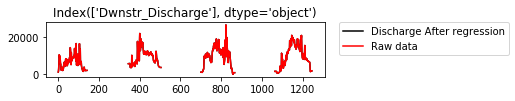

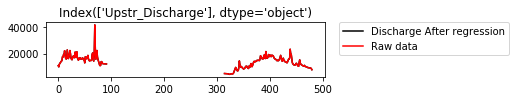

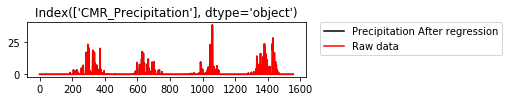

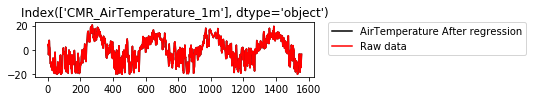

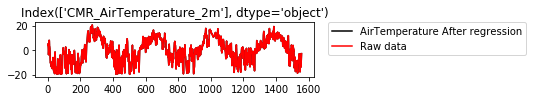

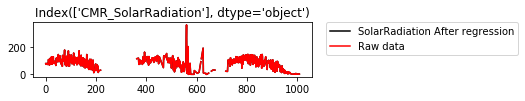

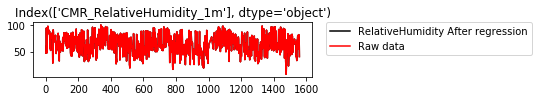

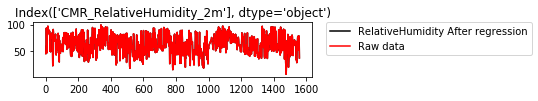

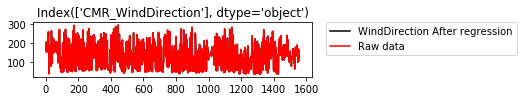

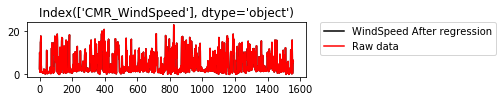

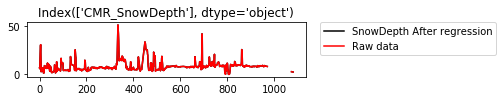

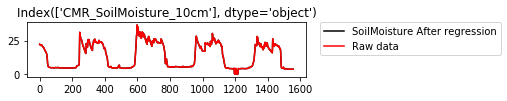

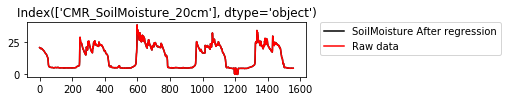

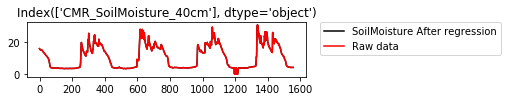

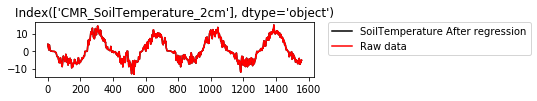

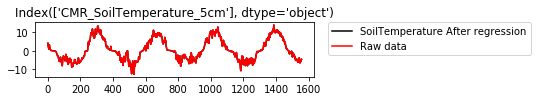

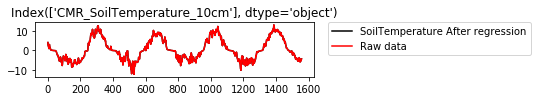

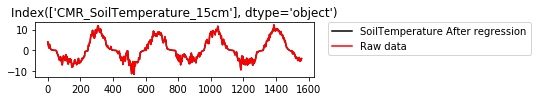

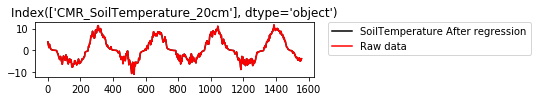

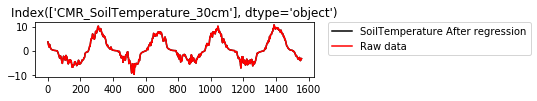

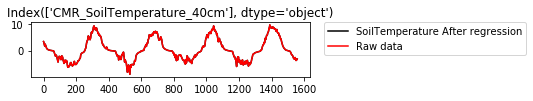

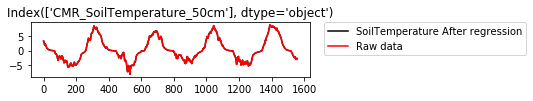

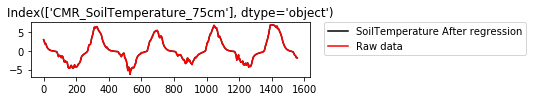

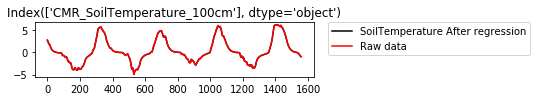

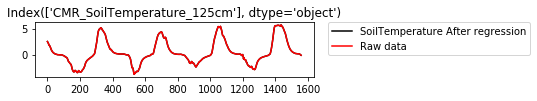

In [17]:
%%time
for i in np.arange(len(stn_names)): # Each met station
    tabReg = stn_table_dic[i]  # extract the table for station i from the dictionary
    for j in np.arange(len(var_names)): # loop across variables, not looping for discharge
        var = var_names[j] # for each meteorology variable
        if var in pd.unique(np.array([c.split('_')[1] for c in tabReg.columns])):
            ind = get_ind(tabReg,var)
            print(i+1,"/",len(stn_names),"in process:",stn_names[i],var)
            # Fill single variable from multiple stations
            nn = fromEveryStationPoolAvariable(stn_names, var, ind, stn_table_dic)
            ## nn is a df storing the all the data for the same variable(var)

            # Do regression across stations for met station i, variable j
            result = regressionAtStationForAvariable(nn, stn_names[i], var)
            regressed_cols = pd.Series(list(set(result.columns) & set(tabReg.columns)),dtype='object') # column where regression is done
            
            # Update table3 with regression results
            #print('Finishing regression on Station', stn_names[i], var) 
            for k in np.arange(len(regressed_cols)):
                rcol=regressed_cols[k]
                reg=result[rcol]
                table3.loc[reg.index[0]:reg.index[-1],rcol] = np.array(reg)
        else:
            print("No",var,"data at station",stn_names[i])
        print(' ')

In [18]:
# Write indicators of regression into flag table
for j in range(len(col_names)):
    col = col_names[j]
    for m in table3[col].index:  
        if str(table2[col][m]) == 'nan':
            if str(table3[col][m])!= 'nan':
                flag_table3[col][m] = int(3)

In [19]:
# Check the regression values and delete out of range values
for col in col_names:
    outvalues(table, table3, flag_table3, col)

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original dat

In [20]:
# Store the data table and the flag table
table3.to_csv('3_'+watershed+'_Regression.csv', sep=',')
flag_table3.to_csv('3_'+watershed+'_Regression_Flag.csv', sep=',')

# 4. Data filling method: Climate Catalog

In [21]:
# Extract discharge table
DischargeTable = pd.DataFrame(index = table3.index)
for i in np.arange(len(nameStrflwStation)):
    DischargeTable[nameStrflwStation[i]+'_Discharge'] = table3.loc[:,nameStrflwStation[i]+'_Discharge']
DischargeTable.head(2)

Dwnstr_Discharge  Upstr_Discharge
DateTime                                     
2012-09-26               NaN              NaN
2012-09-27               NaN              NaN

In [22]:
y3 = {}
for i in np.arange(len(table3.columns)):
    col_name = table3.columns[i]
    range_y3 = np.where(~np.isnan(table3[col_name].to_numpy()))[0]
    start = range_y3[0]
    end = range_y3[-1]
    y3[i] = table3[col_name][start:end+1]
AnT = funcClimateCatalog(table3, y3, 270, watershed, 0.7) # divide the data by year
table4,whereClimateCat = AssembleClimateCatalog(AnT, y3, table3, watershed)

/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions/Source_QC_functions_L.py:135: RuntimeWarning: Mean of empty slice
  AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions/Source_QC_functions_L.py:137: RuntimeWarning: All-NaN slice encountered
  AnnualMax = (np.nanmax(AnnualTable,axis=0)) # for outliers MAx
/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions/Source_QC_functions_L.py:138: RuntimeWarning: All-NaN slice encountered
  AnnualMin = (np.nanmin(AnnualTable,axis=0)) # minimum


0 Dwnstr_Discharge 0
1 Upstr_Discharge 0
2 CMR_Precipitation 0
3 CMR_AirTemperature_1m 1
4 CMR_AirTemperature_2m 1
5 CMR_SolarRadiation 33
6 CMR_RelativeHumidity_1m 1
7 CMR_RelativeHumidity_2m 1
8 CMR_WindDirection 1
9 CMR_WindSpeed 1
10 CMR_SnowDepth 3
11 CMR_SoilMoisture_10cm 0
12 CMR_SoilMoisture_20cm 0
13 CMR_SoilMoisture_40cm 0
14 CMR_SoilTemperature_2cm 0
15 CMR_SoilTemperature_5cm 0
16 CMR_SoilTemperature_10cm 0
17 CMR_SoilTemperature_15cm 0
18 CMR_SoilTemperature_20cm 0
19 CMR_SoilTemperature_30cm 0
20 CMR_SoilTemperature_40cm 0
21 CMR_SoilTemperature_50cm 0
22 CMR_SoilTemperature_75cm 0
23 CMR_SoilTemperature_100cm 0
24 CMR_SoilTemperature_125cm 0


In [23]:
# Write indicators of ClimateCatalog into flag table4
flag_table4 = copy.deepcopy(flag_table3)
for j in range(len(col_names)):
    col = col_names[j]
    for m in table4[col].index:  
        if str(table3[col][m]) == 'nan':
            if str(table4[col][m])!= 'nan':
                flag_table4[col][m] = int(4)

In [24]:
# Check the regression values and delete out of range values
for col in col_names:
    outvalues(table, table4, flag_table4, col)

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original dat

In [25]:
# Store the data table and the flag table
table4.to_csv('4_'+watershed+'_ClimateCatalog.csv', sep=',')
flag_table4.to_csv('4_'+watershed+'_ClimateCatalog_Flag.csv', sep=',')

In [26]:
table4.head()

Dwnstr_Discharge  Upstr_Discharge  CMR_Precipitation  \
DateTime                                                           
2012-09-26               NaN              NaN                0.0   
2012-09-27               NaN              NaN                0.0   
2012-09-28               NaN              NaN                0.0   
2012-09-29               NaN              NaN                0.0   
2012-09-30               NaN              NaN                0.0   

            CMR_AirTemperature_1m  CMR_AirTemperature_2m  CMR_SolarRadiation  \
DateTime                                                                       
2012-09-26               4.402000               4.799000                 NaN   
2012-09-27               3.702500               3.806250                 NaN   
2012-09-28               3.887917               4.010417                 NaN   
2012-09-29               1.569583               1.656250                 NaN   
2012-09-30              -3.887917              -3.833333                 NaN   

            CMR_RelativeHumidity_1m  CMR_RelativeHumidity_2m  \
DateTime                                                       
2012-09-26                47.246000                45.355000   
2012-09-27                54.348750                53.600833   
2012-09-28                61.113750                60.063333   
2012-09-29                61.483333                60.847917   
2012-09-30                94.012500                93.731250   

            CMR_WindDirection  CMR_WindSpeed  ...  CMR_SoilTemperature_5cm  \
DateTime                                      ...                            
2012-09-26         188.730000       2.531000  ...                 4.068300   
2012-09-27         187.329167      10.130000  ...                 2.844875   
2012-09-28         175.283333       7.510417  ...                 2.517208   
2012-09-29         159.828750       7.041250  ...                 2.198292   
2012-09-30         205.922083       0.950833  ...                 1.632375   

            CMR_SoilTemperature_10cm  CMR_SoilTemperature_15cm  \
DateTime                                                         
2012-09-26                  4.042000                  3.990300   
2012-09-27                  2.878958                  3.031125   
2012-09-28                  2.517750                  2.643750   
2012-09-29                  2.249625                  2.423750   
2012-09-30                  1.703875                  1.926000   

            CMR_SoilTemperature_20cm  CMR_SoilTemperature_30cm  \
DateTime                                                         
2012-09-26                  3.930800                  3.668900   
2012-09-27                  3.146417                  3.291375   
2012-09-28                  2.749875                  2.918208   
2012-09-29                  2.547458                  2.730958   
2012-09-30                  2.096417                  2.383667   

            CMR_SoilTemperature_40cm  CMR_SoilTemperature_50cm  \
DateTime                                                         
2012-09-26                  3.399500                  3.250000   
2012-09-27                  3.254500                  3.209875   
2012-09-28                  2.931708                  2.949083   
2012-09-29                  2.747625                  2.767833   
2012-09-30                  2.484375                  2.557958   

            CMR_SoilTemperature_75cm  CMR_SoilTemperature_100cm  \
DateTime                                                          
2012-09-26                  3.050300                   2.792800   
2012-09-27                  2.974083                   2.725750   
2012-09-28                  2.843542                   2.650667   
2012-09-29                  2.715500                   2.564125   
2012-09-30                  2.590000                   2.474458   

            CMR_SoilTemperature_125cm  
DateTime                               
2012-09-26                   2.514700  

In [27]:
flag_table4.head()

Dwnstr_Discharge  Upstr_Discharge  CMR_Precipitation  \
DateTime                                                           
2012-09-26               NaN              NaN                1.0   
2012-09-27               NaN              NaN                1.0   
2012-09-28               NaN              NaN                1.0   
2012-09-29               NaN              NaN                1.0   
2012-09-30               NaN              NaN                1.0   

            CMR_AirTemperature_1m  CMR_AirTemperature_2m  CMR_SolarRadiation  \
DateTime                                                                       
2012-09-26                    1.0                    1.0                 NaN   
2012-09-27                    1.0                    1.0                 NaN   
2012-09-28                    1.0                    1.0                 NaN   
2012-09-29                    1.0                    1.0                 NaN   
2012-09-30                    1.0                    1.0                 NaN   

            CMR_RelativeHumidity_1m  CMR_RelativeHumidity_2m  \
DateTime                                                       
2012-09-26                      1.0                      1.0   
2012-09-27                      1.0                      1.0   
2012-09-28                      1.0                      1.0   
2012-09-29                      1.0                      1.0   
2012-09-30                      1.0                      1.0   

            CMR_WindDirection  CMR_WindSpeed  ...  CMR_SoilTemperature_5cm  \
DateTime                                      ...                            
2012-09-26                1.0            1.0  ...                      1.0   
2012-09-27                1.0            1.0  ...                      1.0   
2012-09-28                1.0            1.0  ...                      1.0   
2012-09-29                1.0            1.0  ...                      1.0   
2012-09-30                1.0            1.0  ...                      1.0   

            CMR_SoilTemperature_10cm  CMR_SoilTemperature_15cm  \
DateTime                                                         
2012-09-26                       1.0                       1.0   
2012-09-27                       1.0                       1.0   
2012-09-28                       1.0                       1.0   
2012-09-29                       1.0                       1.0   
2012-09-30                       1.0                       1.0   

            CMR_SoilTemperature_20cm  CMR_SoilTemperature_30cm  \
DateTime                                                         
2012-09-26                       1.0                       1.0   
2012-09-27                       1.0                       1.0   
2012-09-28                       1.0                       1.0   
2012-09-29                       1.0                       1.0   
2012-09-30                       1.0                       1.0   

            CMR_SoilTemperature_40cm  CMR_SoilTemperature_50cm  \
DateTime                                                         
2012-09-26                       1.0                       1.0   
2012-09-27                       1.0                       1.0   
2012-09-28                       1.0                       1.0   
2012-09-29                       1.0                       1.0   
2012-09-30                       1.0                       1.0   

            CMR_SoilTemperature_75cm  CMR_SoilTemperature_100cm  \
DateTime                                                          
2012-09-26                       1.0                        1.0   
2012-09-27                       1.0                        1.0   
2012-09-28                       1.0                        1.0   
2012-09-29                       1.0                        1.0   
2012-09-30                       1.0                        1.0   

            CMR_SoilTemperature_125cm  
DateTime                               
2012-09-26                        1.0  

In [28]:
table4.shape

(1558, 25)

In [29]:
flag_table4.shape

(1558, 25)